In [ ]:
#!/usr/bin/env python
import os
from datetime import datetime

import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn, optim

from src.data import preprocess_data, embed_data

## 1. Data Preprocessing

In [ ]:
df_train, df_eval = preprocess_data()
df_train, df_eval = embed_data(df_train, df_eval)

X = df_train.drop(columns=['EventType', 'MatchID', 'PeriodID', 'ID']).values
y = df_train['EventType'].values

X_id = df_eval['ID'].values
X_eval = df_eval.drop(columns=['MatchID', 'PeriodID', 'ID']).values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

## 2. Model Training

In [ ]:
# For Kaggle submission save
def save_predictions_model(clf, params, accuracy):
    clf.fit(X, y)
    preds = clf.predict(X_eval)
    pred_df = pd.DataFrame({'ID': X_id, 'EventType': preds})
    # <clf name>/<params>/<filename>_predictions.csv
    params = params.replace(' ', '')
    today = datetime.today().strftime('%Y%m%d')
    file_folder = f"pred-{today}/{clf.__class__.__name__}-{accuracy}/{params}/"
    os.makedirs(file_folder, exist_ok=True)
    file_path = os.path.join(file_folder, f"{clf.__class__.__name__}_predictions.csv")
    pred_df.to_csv(file_path, index=False)
    print(f"Predictions saved to {file_path}")
    return file_folder


def test_clf(clf, params):
    y_pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    print(f"{clf.__class__.__name__} Test set: ", accuracy_score(y_valid, y_pred), f"Params: {params}")
    # plot confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    return acc

## CNN

In [33]:
# CNN Model
class CNNBinaryClassifier(nn.Module):
    def __init__(self, criterion, optimizer, lr, tol=1e-4, max_epochs=1000):
        super(CNNBinaryClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),  # Input: [batch_size, 1, 200]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # Output: [batch_size, 16, 100]
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # Output: [batch_size, 32, 50]
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 50, 1),
            nn.Sigmoid()
        )
        self.criterion = criterion
        self.tol = tol
        self.max_epochs = max_epochs
        self.optimizer = optimizer(self.parameters(), lr=lr)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

    def fit(self, X, y):
        X_tensor = X if isinstance(X, torch.Tensor) else torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        y_tensor = y if isinstance(y, torch.Tensor) else torch.tensor(y, dtype=torch.float32)

        epoch = 0
        loss_prev_5 = [float('inf')] * 5  # Start with large values
        from tqdm.notebook import tqdm
        with tqdm(total=self.max_epochs, desc=f"Training Epoch {epoch}, Loss: {loss_prev_5[-1]:.4f}") as pbar:
            while not all([abs(loss - loss_prev_5[0]) < self.tol for loss in loss_prev_5]) and epoch < self.max_epochs:
                self.optimizer.zero_grad()
                outputs = self(X_tensor)
                loss = self.criterion(outputs.squeeze(), y_tensor)
                loss.backward()
                self.optimizer.step()

                # Update loss history
                loss_prev_5.pop(0)
                loss_prev_5.append(loss.item())

                # Update progress bar
                epoch += 1
                pbar.set_description(f"Training Epoch {epoch}, Loss: {loss_prev_5[-1]:.4f}")
                pbar.update(1)

            print("Max epochs reached; stopping training.") if epoch >= self.max_epochs else print(
                "Convergence reached; stopping training.")

    @torch.no_grad()
    def get_params(self):
        return f"crit={self.criterion.__class__.__name__},opt={self.optimizer.__class__.__name__}lr={self.optimizer.param_groups[0]['lr']}"

    @torch.no_grad()
    def predict(self, X):
        X_tensor = X if isinstance(X, torch.Tensor) else torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        pred = self(X_tensor).reshape(-1)
        return (pred.squeeze() > 0.5).int().numpy()

Training Epoch 0, Loss: inf:   0%|          | 0/1000 [00:00<?, ?it/s]

Convergence reached; stopping training.
CNNBinaryClassifier Test set:  0.7429906542056075 Params: crit=BCELoss,opt=Adamlr=0.001


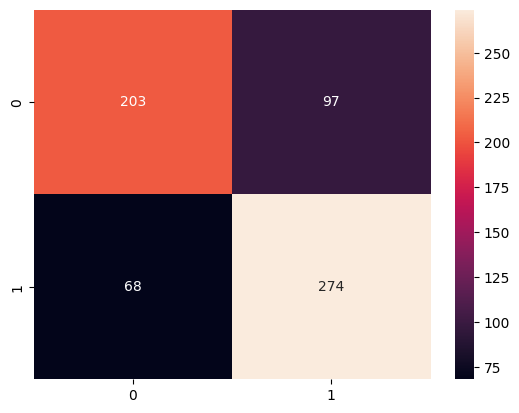

In [29]:
# Train on a subset of the data
model_cnn_train = CNNBinaryClassifier(criterion=nn.BCELoss(), optimizer=optim.Adam, lr=1e-3, tol=1e-4, max_epochs=1000)
model_cnn_train.fit(X_train, y_train)

# Evaluate on the test set
acc = test_clf(model_cnn_train, model_cnn_train.get_params())

In [30]:
# Save predictions
save_predictions_model(model_cnn_train, model_cnn_train.get_params(), acc)

Training Epoch 0, Loss: inf:   0%|          | 0/1000 [00:00<?, ?it/s]

Convergence reached; stopping training.
Predictions saved to pred/CNNBinaryClassifier/crit=BCELoss,opt=Adamlr=0.001/CNNBinaryClassifier_predictions.csv
